<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">MNIST: CNN</h1>
</div>

Problem Type: Multi-classification

## Evaluation Metric

In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [2]:
data_dir = "../input/digit-recognizer"

In [3]:
TARGET = "label"

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

A best practise is to include all libraries here.  However, I will put a few imports farther down where they are first used so beginners can learn with an "as needed" approach.

In [4]:
import os
import time
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Creating a few functions that we will reuse in each project.

In [5]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [6]:
def create_submission(model_name, target, preds, is_log_target=False):
    if is_log_target:
        #         preds = np.exp(preds)
        preds = np.expm1(preds)

    sample_submission[target] = preds
    if len(model_name) > 0:
        sample_submission.to_csv(f"submission_{model_name}.csv", index=False)
    else:
        sample_submission.to_csv(f"submission.csv", index=False)

    return sample_submission[:5]

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score


def show_scores(gt, yhat):
    f1 = f1_score(gt, yhat, average="macro")
    mse = mean_squared_error(gt, yhat)
    mae = mean_absolute_error(gt, yhat)
    rmse = np.sqrt(mse)
    #     r2_square = r2_score(gt, yhat)

    print(f"f1: {f1:.4f}")

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

- train.csv - Data used to build our machine learning model
- test.csv - Data used to build our machine learning model. Does not contain the target variable
- sample_submission.csv - A file in the proper format to submit test predictions

In [8]:
train, test, sample_submission = read_data(data_dir)

train data: Rows=42000, Columns=785
test data : Rows=28000, Columns=784


In [9]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
FEATURES = [
    col
    for col in train.columns
    if col
    not in [
        "Id",
        TARGET,
        #         TARGET_ENC,
    ]
]

In [11]:
y = train[TARGET]
X = train[FEATURES].copy()

X_test = test[FEATURES].copy()

In [12]:
# Normalize the data
X = X / 255.0
X_test = X_test / 255.0

In [13]:
X = X.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [14]:
# X[:3]

In [15]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y)

In [16]:
y[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((33600, 28, 28, 1), (33600, 10), (8400, 28, 28, 1), (8400, 10))

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Create Models</h1>
</div>

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def get_tf_model01(x_shape):
    print(f"x_shape=")
    #     input_shape = (height, width, channels)
    inputs = keras.Input(shape=(28, 28, 1))

    x = keras.layers.Conv2D(
        64,
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(28, 28, 1),
        kernel_initializer="he_normal",
    )(inputs)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(
        64,
        kernel_size=3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    #     x = keras.layers.MaxPooling2d((2, 2))(x)
    #     x = keras.layers.Conv2D(
    #         128, activation="relu", padding="same", kernel_initializer="he_normal"
    #     )(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)

    #     x = keras.layers.Dense(128, activation="relu")(x)

    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    #     x = keras.layers.Dropout(0.1)(x)

    outputs = keras.layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # rmsprop
        metrics=["accuracy"],
    )

    #     model.compile(
    #         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #         loss="mean_absolute_error",
    #     )

    return model

In [19]:
X_train.shape[1]

28

In [20]:
X.shape[0]

42000

In [21]:
model = get_tf_model01(x_shape=(28, 28))

model.summary()

x_shape=
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)           

2022-07-24 22:05:32.390969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 22:05:32.530962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 22:05:32.531716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 22:05:32.533746: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

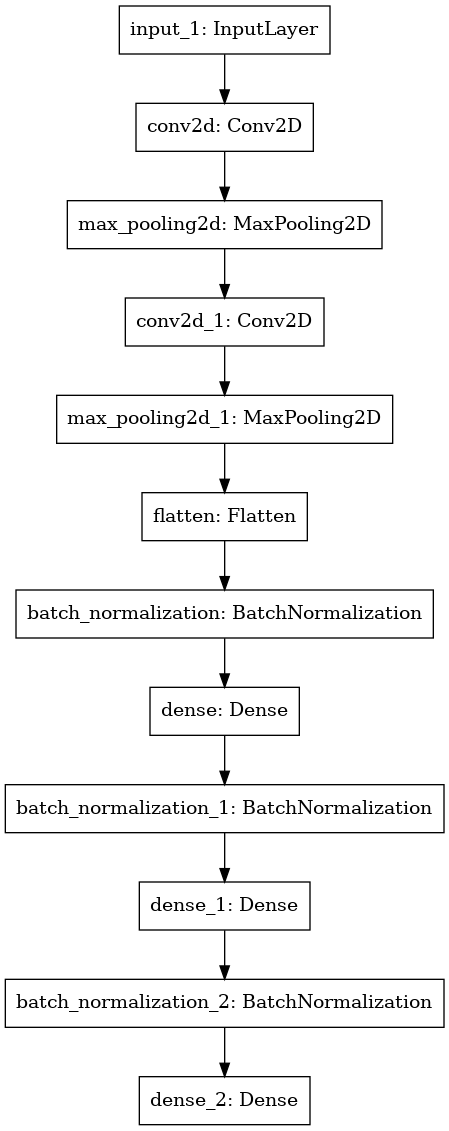

In [22]:
keras.utils.plot_model(model)

In [23]:
%%time

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    # Suppress logging.
    verbose=1,
    validation_data=(X_valid, y_valid),
    # Calculate validation results on 20% of the training data.
#     validation_split = 0.2
)

2022-07-24 22:05:36.457300: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-07-24 22:05:38.223486: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


525/525 [==============================] - 10s 5ms/step - loss: 0.1634 - accuracy: 0.9507 - val_loss: 0.0902 - val_accuracy: 0.9718
Epoch 2/10
525/525 [==============================] - 2s 4ms/step - loss: 0.0661 - accuracy: 0.9797 - val_loss: 0.2238 - val_accuracy: 0.9354
Epoch 3/10
525/525 [==============================] - 2s 4ms/step - loss: 0.0477 - accuracy: 0.9851 - val_loss: 0.0666 - val_accuracy: 0.9788
Epoch 4/10
525/525 [==============================] - 3s 5ms/step - loss: 0.0404 - accuracy: 0.9871 - val_loss: 0.0622 - val_accuracy: 0.9818
Epoch 5/10
525/525 [==============================] - 2s 4ms/step - loss: 0.0353 - accuracy: 0.9897 - val_loss: 0.0520 - val_accuracy: 0.9856
Epoch 6/10
525/525 [==============================] - 2s 5ms/step - loss: 0.0280 - accuracy: 0.9913 - val_loss: 0.0450 - val_accuracy: 0.9868
Epoch 7/10
525/525 [==============================] - 2s 4ms/step - loss: 0.0291 - accuracy: 0.9907 - val_loss: 0.0727 - val_accuracy: 0.9833
Epoch 8/10
525/5

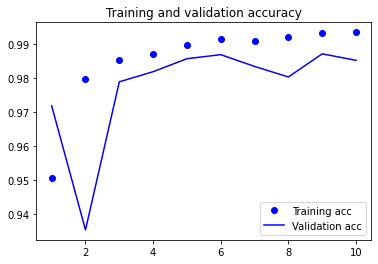

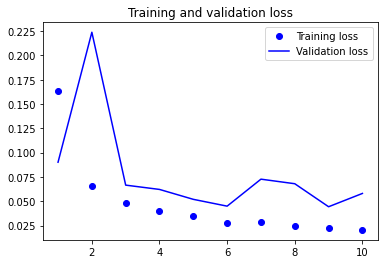

In [24]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Predict and Score

In [25]:
test_loss, test_acc = model.evaluate(X_valid, y_valid)
test_acc

263/263 [==============================] - 1s 3ms/step - loss: 0.0581 - accuracy: 0.9851


0.9851190447807312

In [26]:
valid_preds = model.predict(X_valid)
valid_preds[:5]

array([[2.33911783e-06, 6.24365498e-07, 1.06575999e-05, 3.72876130e-09,
        1.14128881e-07, 1.57101065e-09, 5.95848746e-07, 2.68065570e-08,
        9.99985337e-01, 3.83897429e-07],
       [3.22947957e-09, 9.99996662e-01, 4.68657602e-09, 2.03252367e-12,
        5.44777841e-08, 2.16924867e-10, 4.34617098e-09, 3.30419721e-06,
        1.82033109e-08, 9.96854332e-09],
       [1.06791326e-07, 3.22926103e-10, 7.61357821e-09, 5.14908960e-09,
        7.23781523e-06, 2.47439083e-08, 2.94241476e-09, 2.17965983e-08,
        2.79154278e-07, 9.99992371e-01],
       [6.97095800e-07, 3.34270460e-08, 8.52106382e-07, 5.07649816e-07,
        8.43861053e-05, 6.25206127e-08, 5.22512567e-09, 1.59572475e-04,
        4.62913249e-06, 9.99749243e-01],
       [8.53208846e-08, 2.34984228e-08, 9.15565046e-09, 4.92620389e-09,
        5.98531491e-09, 3.52409444e-08, 5.45351838e-07, 1.14207344e-09,
        9.99999285e-01, 2.59604582e-09]], dtype=float32)

In [27]:
valid_preds = np.argmax(valid_preds, axis=1)

In [28]:
# show_scores(y_valid, valid_preds)

In [29]:
preds = model.predict(X_test)
preds[:5]

array([[3.65270658e-09, 4.59136444e-08, 9.99996066e-01, 3.82666985e-06,
        5.19664145e-10, 3.12095877e-10, 1.35399851e-08, 1.26317872e-07,
        4.05544434e-08, 6.09593098e-10],
       [9.99896526e-01, 3.71194034e-07, 6.43845510e-08, 4.91375522e-06,
        4.49021827e-11, 3.12016482e-07, 9.75720905e-05, 7.71508724e-08,
        2.01701922e-09, 8.69482975e-08],
       [1.23890388e-07, 1.03223829e-08, 1.23726329e-06, 1.96999856e-08,
        7.57831094e-06, 5.10546849e-09, 1.44868446e-08, 9.64249924e-09,
        1.85623594e-05, 9.99972463e-01],
       [9.96909797e-01, 5.15672468e-07, 6.80157927e-06, 2.27739092e-05,
        2.00756153e-06, 2.19322814e-07, 9.10397939e-05, 4.13225462e-05,
        1.10517925e-04, 2.81500653e-03],
       [5.98421801e-09, 2.15969044e-06, 2.53269391e-05, 9.99968529e-01,
        9.58242513e-11, 9.07558757e-08, 7.97999178e-08, 1.06951904e-06,
        2.83627014e-06, 2.73490972e-08]], dtype=float32)

In [30]:
preds = np.argmax(preds, axis=1)

## Submission

In [31]:
# Different TARGET name used in test.csv
ss = create_submission("", "Label", preds)
ss

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
